In [24]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("Optimization")
Pkg.add("OptimizationOptimJL")
Pkg.add("OptimizationBBO")
Pkg.add("DiffEqParamEstim")
Pkg.add("StatsBase")
Pkg.add("SciMLSensitivity")

   Resolving package versions...
  No Changes to `/blue/ferrallm/kelbakkouri/Project.toml`
  No Changes to `/blue/ferrallm/kelbakkouri/Manifest.toml`
   Resolving package versions...
  No Changes to `/blue/ferrallm/kelbakkouri/Project.toml`
  No Changes to `/blue/ferrallm/kelbakkouri/Manifest.toml`
   Resolving package versions...
  No Changes to `/blue/ferrallm/kelbakkouri/Project.toml`
  No Changes to `/blue/ferrallm/kelbakkouri/Manifest.toml`
   Resolving package versions...
  No Changes to `/blue/ferrallm/kelbakkouri/Project.toml`
  No Changes to `/blue/ferrallm/kelbakkouri/Manifest.toml`
   Resolving package versions...
  No Changes to `/blue/ferrallm/kelbakkouri/Project.toml`
  No Changes to `/blue/ferrallm/kelbakkouri/Manifest.toml`
   Resolving package versions...
  No Changes to `/blue/ferrallm/kelbakkouri/Project.toml`
  No Changes to `/blue/ferrallm/kelbakkouri/Manifest.toml`
   Resolving package versions...
  No Changes to `/blue/ferrallm/kelbakkouri/Project.toml`
  No Chan

In [3]:
# Here are all the packages I used
using StatsBase
using CSV
using Plots
using DataFrames
using DifferentialEquations
using SciMLSensitivity
using LsqFit
using DifferentialEquations, RecursiveArrayTools, Plots, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO

# Label your file names Here I have labelled my resistent cells, my naive cells and the treated resistent cells, and resistent naive cells
# I recommend labelling with very easy names 
GFP = "ProcessedCIS.csv"
RFP = "ProcessedRFP.csv"
GFPT = "ProcessedCISTreated.csv"
RFPT = "ProcessedRFPTreated.csv"

"ProcessedRFPTreated.csv"

In [1]:
# This function is used to collect the xdata and ydata arrays
function process_day_averages(file_path::String)
    df = CSV.read(file_path, DataFrame)
    
    x = []  # Will store day numbers
    y = []  # Will store day averages
    
    current_day = 1
    for row in eachrow(df)
        day_average = row[:"Day Averages"]
        if !ismissing(day_average) && !isempty(strip(string(day_average)))
            if current_day == 9
                push!(x, current_day)
                push!(y, (day_average+y[8])*.51)
                current_day += 1
            end
            push!(x, current_day)
            push!(y, day_average)
            current_day += 1
        end
    end
    
    return x, y
end

# This is for proccessing triplicate samples or more samples. This can help you see how various samples are behaving
function process_sample_averages(file_path::String)
    df = CSV.read(file_path, DataFrame)
    total = Float64[]
    y1 = Float64[] # ADD MORE LISTS HERE
    y2 = Float64[]
    y3 = Float64[]
    
    for (i, row) in enumerate(eachrow(df))
        sample_average = row[:"Sample Averages"]
        if !ismissing(sample_average) && !isempty(strip(string(sample_average)))
            push!(total, sample_average)
        end
    end
    
    println("Total sample averages: ", length(total))
    
    x = 1:Int(length(total)/3)  # Assuming y1, y2, and y3 have the same length ADD MORE HERE IF YOU WANT MORE LISTS
    
    for i in 1:length(total) # MAKE SURE TO ADD A CASE FOR EXTRA OR LESS DUPLICATES SAMPLES
        if i % 3 == 1
            push!(y1, total[i])
        elseif i % 3 == 2
            push!(y2, total[i])
        else
            push!(y3, total[i])
        end
    end
    
    println("Length of y1: ", length(y1))
    println("Length of y2: ", length(y2))
    println("Length of y3: ", length(y3))
    
    return x, y1, y2, y3
end

# This is how I plot a file
function plot_results(file, title::String, xlabel::String, ylabel::String)
    x, y = process_day_averages(file)
    
    p = plot(x, y, 
         title=title, 
         xlabel=xlabel, 
         ylabel=ylabel, 
         marker=:circle,
         line=:solid,
         legend=false)
    return p  # Return the plot object
end

# This is how you plot various samples into a plot
function plot_sample_averages(x, y1, y2, y3, title::String, xlabel::String, ylabel::String)
    plot(x, y1, 
         title=title, 
         xlabel=xlabel, 
         ylabel=ylabel, 
         marker=:circle,
         line=:solid,
         label="Set 1")
    plot!(x, y2, 
          marker=:square,
          line=:dash,
          label="Set 2")
    plot!(x, y3, 
          marker=:diamond,
          line=:dot,
          label="Set 3")
    #savefig("$title.png")  # Save the plot as a PNG file
    display(current())  # Display the plot
end

plot_sample_averages (generic function with 1 method)

Total sample averages: 27
Length of y1: 9
Length of y2: 9
Length of y3: 9


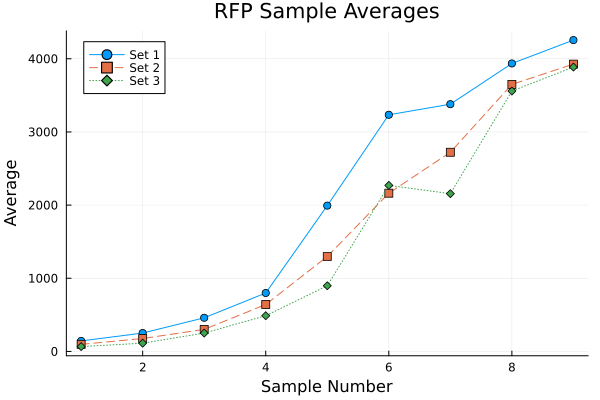

In [5]:
# If you still want to process and plot sample averages for one of the datasets, you can do it like this:
sample_x, sample_y1, sample_y2, sample_y3 = process_sample_averages(RFP)
plot_sample_averages(sample_x, sample_y1, sample_y2, sample_y3, "RFP Sample Averages", "Sample Number", "Average")

I find it very useful to plot all your data so you understand what it looks like. This is my version of this. 

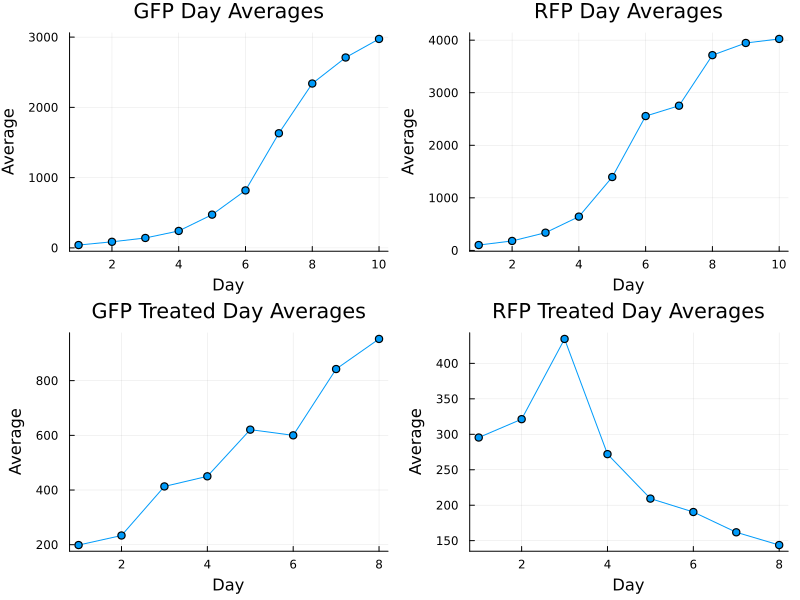

In [6]:
# Create a 2x2 grid of plots
p1 = plot_results(GFP, "GFP Day Averages", "Day", "Average")
p2 = plot_results(RFP, "RFP Day Averages", "Day", "Average")
p3 = plot_results(GFPT, "GFP Treated Day Averages", "Day", "Average")
p4 = plot_results(RFPT, "RFP Treated Day Averages", "Day", "Average")

# Combine the plots into a 2x2 grid
combined_plot = plot(p1, p2, p3, p4, layout = (2, 2), size = (800, 600))

# Save the combined plot
savefig(combined_plot, "Combined_Day_Averages.png")

# Display the combined plot
display(combined_plot)

In [80]:
function setUpProblem(modelType, xdata, ydata, solver, u0)
    prob = ODEProblem(modelType, u0, tspan, p)  # Declare initial problem
    sol = solve(prob, solver, saveat=xdata)  # Solve the ODE
    cost_function = build_loss_objective(prob, solver, L2Loss(xdata, ydata), Optimization.AutoForwardDiff(), maxiters=10000, verbose=false)  # Define the cost function
    optprob = Optimization.OptimizationProblem(cost_function, p)  # Define the optimization problem
    optsol = solve(optprob, BFGS())  # Solve the optimization problem
    optimized_params = optsol.minimizer  # Access optimized parameters
    optimized_prob = ODEProblem(modelType, [ydata[1]], tspan, optimized_params)  # New ODE problem with optimized parameters
    xdata_dense = range(xdata[1], xdata[end], length=1000)  # 1000 points in range
    optimized_sol = solve(optimized_prob, solver, reltol=1e-15, abstol=1e-15, saveat=xdata_dense)  # Solve with optimized parameters
    return optimized_params, optimized_sol, optimized_prob
end

function calculate_bic(prob, xdata, ydata, solver)
    sol = solve(prob, solver, reltol=1e-15, abstol=1e-15, saveat=xdata)  # Solve with optimized parameters
    residuals = [ydata[i] - sol[i][1] for i in 1:length(xdata)]  # Calculate residuals
    ssr = sum(residuals .^ 2)  # Sum of squared residuals
    n, k = length(xdata), length(prob.p)  # Number of data points and parameters
    bic = n * log(ssr / n) + k * log(n)  # Calculate BIC
    return bic, ssr
end

calculate_bic (generic function with 2 methods)

Processing model: f_withoutD
Processing model: f_withD
Processing model: gompertz_growth!
Processing model: gompertz_growth_D!
Processing model: delayed_exponential!
Processing model: delayed_logistic!
Processing model: monod!
Processing model: logistic_birth_death!


┌ Warning: At t=1.0000012207733417, dt was forced below floating point epsilon 2.220446049250313e-16, and step error estimate = 42.162927690921634. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Pma4a/src/integrator_interface.jl:623
┌ Warning: At t=1.0000012207905136, dt was forced below floating point epsilon 2.220446049250313e-16, and step error estimate = 1.0171062442956418. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Pma4a/src/integrator_interface.jl:623


An error occurred while processing model logistic_birth_death!:
BoundsError([[102.0702381]], (2,))
Processing model: logistic_with_lag!


┌ Warning: At t=1.0000012207905136, dt was forced below floating point epsilon 2.220446049250313e-16, and step error estimate = 1.0171062442956418. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/Pma4a/src/integrator_interface.jl:623


The best model is: f_withD


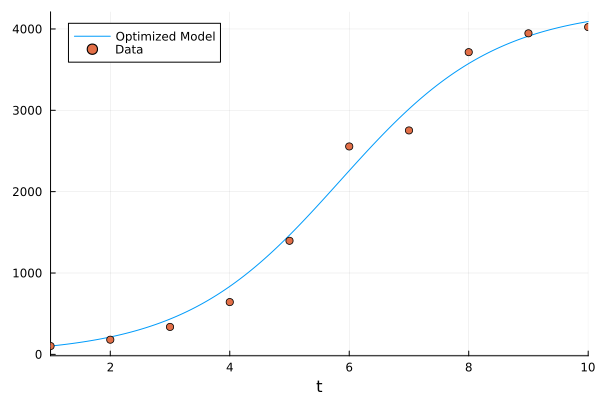


BIC values for all models:


Row,Model,BIC
,String,Float64
1,f_withD,107.605
2,logistic_with_lag!,107.605
3,f_withoutD,107.605
4,delayed_logistic!,107.605
5,monod!,121.251
6,gompertz_growth_D!,144.426
7,gompertz_growth!,162.689
8,delayed_exponential!,162.689
9,logistic_birth_death!,NaN


"bic_values.csv"

In [83]:
 # Only two parameters: r and k
solver = Tsit5()
start, stop = 1.0, 10.0 #make sure to update to your range of values
tspan = (start, stop)
xdata, ydata = process_day_averages(RFP) #here is where you change file
u0 = [ydata[1]] #This is the initial point, usually the first data point
p = [0.5, maximum(ydata), 0.5] #I have three paramete

#These are place holders for finding the best parameters
best_SSR = Inf
best_BIC = Inf
best_p = plot()
best_model = f_withoutD

bic_values = Dict()

# Cycles through each of the possible untreated models
for model in untreated_models
    model_name = string(model)
    println("Processing model: ", model_name)
    
    try
        optpar, optsol, optprob = setUpProblem(model, xdata, ydata, solver, u0) #This jogs all the needed data for optimization
        cur_bic, cur_ssr = calculate_bic(optprob, xdata, ydata, solver) #This generates BIC and SSR
        bic_values[model_name] = cur_bic #This helps create BIC data. 
        
        #IF THE BEST MODEL IS THE ONE BEING EVALUATED RESET BESTS
        if cur_bic < best_BIC
            best_model = model
            best_SSR = cur_ssr
            best_BIC = cur_bic
            best_p = plot(optsol, label="Optimized Model")
            scatter!(best_p, xdata, ydata, label="Data")
        end
        
    catch e
        println("An error occurred while processing model $(model_name):")
        println(e)
        bic_values[model_name] = NaN
    end
end

println("The best model is: ", best_model)
display(best_p)

# Create a DataFrame from the BIC values
bic_table = DataFrame(Model = String[], BIC = Float64[])
for (model, bic) in bic_values
    push!(bic_table, (model, bic))
end

# Sort the table by BIC value
sort!(bic_table, :BIC)

# Display the table
println("\nBIC values for all models:")
display(bic_table)

# Optionally, save the table to a CSV file
CSV.write("bic_values.csv", bic_table)

In [74]:
# ALL THE MODELS
#WITHOUT DEATH
# Base logistic growth modelwithout drug
# Base logistic growth model without drug, estimating base parameters (r, k)
# Define the ODE function
#FUNCTIONS WITH DEATH TERM
function f_withD(du, u, p, t)
    r, k, d = p
    du[1] = u[1] * r * (1 - u[1] / k) - u[1]*d
end

# Logistic growth model with both subtractive and multiplicative drug terms, estimating (r, k, d, e)
function f_with_multiplicative_D(du, u, p, t, known)
    e = p
    r, k, d = known
    du[1] = u[1] * r * (1 - u[1] / k) * (1 - e) - u[1] * d
end

# Logistic growth model with subtractive drug term, estimating (cd) and using known (r, k)
function f_with_subtractive_D(du, u, p, t, known)
    cd = p[1]
    r, k, d = known
    du[1] = u[1] * r * (1 - u[1] / k) - u[1] * cd - u[1] * d
end

# Logistic growth model with multiplicative drug term, estimating (cg) and using known (r, k)
function f_with_subtractive_and_multiplicative_D(du, u, p, t, known)
    cg, cd = p[1], p[2]
    r, k, d = known
    du[1] = u[1] * r * (1 - u[1] / k) * (1 - cg) - u[1] * cd - u[1] * d
end

function f_withoutD(du, u, p, t)
    r, k = p[1], p[2]
    du[1] = u[1] * r * (1 - u[1] / k)
end

# Logistic growth model with both subtractive and multiplicative drug terms, estimating (r, k, d, e)
function f_with_multiplicative(du, u, p, t, known)
    e = p[1]
    known = r, k
    du[1] = u[1] * r * (1 - u[1] / k) * (1 - e)
end

# Logistic growth model with subtractive drug term, estimating (cd) and using known (r, k)
function f_with_subtractive(du, u, p, t, known)
    cd = p[1]
    r, k, d = known
    du[1] = u[1] * r * (1 - u[1] / k) - u[1] * cd - u[1] * d
end
# Logistic growth model with both subtractive and multiplicative drug terms, using known (r, k) and estimating (cd, cg)
function f_with_subtractive_and_multiplicative(du, u, p, t, known)
    cd, cg = p
    r, k = known
    du[1] = u[1] * r * (1 - u[1] / k) * (1 - cg) - u[1] * cd
end

function gompertz_growth!(du, u, p, t)
    a, b = p # Growth rate parameters
    du[1] = a * u[1] * exp(-b * t)
end

function gompertz_growth_D!(du, u, p, t)
    a, b, d = p # Growth rate parameters
    du[1] = a * u[1] * exp(-b * t) - u[1] * d
end

function delayed_exponential!(du, u, p, t)
    r, t_lag = p
    growth_rate = t >= t_lag ? r : 0.0 # Growth starts after t_lag
    du[1] = growth_rate * u[1]
end

function delayed_logistic!(du, u, p, t)
    r, K, t_lag = p
    growth_rate = t >= t_lag ? r : 0.0
    du[1] = growth_rate * u[1] * (1 - u[1] / K)
end

function monod!(du, u, p, t)
    r, K = p # Maximum growth rate, half-saturation constant
    du[1] = r * u[1] * (K / (K + u[1]))
end

function logistic_birth_death!(du, u, p, t)
        b, d, K = p #Birth rate, Death Rate, Carrying capacity
        du[1] = u[1]*(b-d)*(1-(u[1]/K))
end

function f_treated(du, u, p, t)
    cg, cd = p[1], p[2] #[0.4466451792986589, 1818.5367436460813, -0.015369738570907876]
    du[1] = u[1] * 0.4466451792986589 * (1 - u[1] / 1818.5367436460813) * (1-4*cg) - u[1] * cd * 4  - u[1] * -0.015369738570907876
end

function f_treated_no_drug_death(du, u, p, t)
    cg = p[1] #[0.4466451792986589, 1818.5367436460813, -0.015369738570907876]
    du[1] = u[1] * 0.4466451792986589 * (1 - u[1] / 1818.5367436460813) * (1-4*cg) - u[1] * -0.015369738570907876
end

function f_treated_accum(du, u, p, t)
    cg, cd, k_accum = p[1], p[2], p[3] # Add accumulation rate parameter
    accumulated_drug = 4.0 # Initial drug concentration

    # Calculate accumulated drug based on dosage schedule (every 2 days)
    days_since_dose = t % 2.0 
    if days_since_dose == 0.0
        accumulated_drug = 4.0 # Reset dosage
    end
    
    # Assume linear accumulation for simplicity (you can change this)
    accumulated_drug += k_accum * days_since_dose #k_accum controls the rate per day
    #OR
    #accumulated_drug = min(accumulated_drug + k_accum*days_since_dose, max_drug_concentration)

    du[1] = u[1] * 0.4466451792986589 * (1 - u[1] / 1818.5367436460813) * (1-cg*accumulated_drug) - u[1] * cd * accumulated_drug - u[1] * -0.015369738570907876
end

function f_treated_accum_no_drug_death(du, u, p, t)
    cg, k_accum = p[1], p[2] # Add accumulation rate parameter
    accumulated_drug = 4.0 # Initial drug concentration

    # Calculate accumulated drug based on dosage schedule (every 2 days)
    days_since_dose = t % 2.0 
    if days_since_dose == 0.0
        accumulated_drug = 4.0 # Reset dosage
    end
    
    # Assume linear accumulation for simplicity (you can change this)
    accumulated_drug += k_accum * days_since_dose #k_accum controls the rate per day
    #OR
    #accumulated_drug = min(accumulated_drug + k_accum*days_since_dose, max_drug_concentration)

    du[1] = u[1] * 0.4466451792986589 * (1 - u[1] / 1818.5367436460813) * (1-cg*accumulated_drug) - u[1] * -0.015369738570907876
end

# Define the cancer model
function cancer_model!(du, u, p, t)
    N, P = u  # N: naïve cells, P: persistent cells
    Olaparib = p[1]  # PARP: drug concentration, GLN: glutamine level

    # Growth terms
    growth_N = 0.033280724664674 * N * (1 - (N + P) / 15.0361586740725)
    growth_P = 0.0345735478962347 * P * (1 - (N + P) / 6.15404191932215)

    # Drug and glutamine effects
    olaparib_N = 0.015910105351181498 * (Olaparib / 20) * N
    olaparib_P = 0.012197562106327444 * (Olaparib / 20) * P

    # ODEs
    du[1] = growth_N - olaparib_N  # Naive cells
    du[2] = growth_P - olarparib_P  # Persistent cells
    du[3] = du[1] + du[2]  # Total population
end

function logistic_with_lag!(du, u, p, t)
    r, K, t_lag = p
    if t < t_lag
        du[1] = 0.0  # No growth during the lag phase
    else
        du[1] = r * u[1] * (1 - u[1] / K)  # Logistic growth after the lag phase
    end
end

function f_treated_with_lag!(du, u, p, t)
    cg, cd, t_lag = p[1], p[2], p[3]
    if t < t_lag
        du[1] = 0.0  # No growth during the lag phase
    else
        du[1] = u[1] * 0.4466451792986589 * (1 - u[1] / 1818.5367436460813) * (1 - 4 * cg) - u[1] * cd * 4 - u[1] * -0.015369738570907876
    end
end

# Untreated type models
untreated_models = [
    f_withoutD,
    f_withD,
    gompertz_growth!,
    gompertz_growth_D!,
    delayed_exponential!,
    delayed_logistic!,
    monod!,
    logistic_birth_death!,
    logistic_with_lag!
]

# Treated type models
treated_models = [
    f_treated,
    f_treated_no_drug_death,
    f_treated_accum,
    f_treated_accum_no_drug_death,
    f_treated_with_lag!,
    f_with_subtractive_D,
    f_with_multiplicative_D,
    f_with_subtractive_and_multiplicative_D,
    f_with_subtractive,
    f_with_multiplicative,
    f_with_subtractive_and_multiplicative
]

println("models")

models
